# #Masks Throughout COVID-19: A Twitter Sentiment Analysis

## Modeling

## Table of contents
1. [Introduction](#Introduction)
2. [The problem domain](#The-problem-domain)
3. [Required libraries](#Required-libraries)
4. [Step 1: Prepping the data](#Step-1:-Prepping-the-data)

    - [Train-test split](#Train-test-split)
    
    
5. [Step 2: Modeling](#Step-2:-Modeling)

    - [Parameter tuning](#Parameter-tuning)
    - [Train final model](#Train-final-model)


6. [Step 3: Reproducibility](#Step-3:-Reproducibility)
7. [Conclusions](#Conclusions)
8. [Acknowledgements](#Acknowledgements)

## Introduction

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

After scraping Twitter with [Twint](https://github.com/twintproject/twint), [Eric Blander](https://github.com/EricB10) and [I](https://github.com/p-szymo) used natural language processing (NLP) techniques to analyze the sentiment of tweets relating to masks and coronavirus.

Through text processing, exploratory data analysis and feature engineering, we looked for insights into how important words, topics, and subjectivity relate to sentiment.

These steps, as well as answers to some initial questions about the data and the project, can be seen in the previous [notebook](03_nlp_features_eda.ipynb).

In this notebook, we will create predictive models that classify tweets as *negative*, *neutral*, or *positive*. This will help us provide further insight and confirm our findings made during EDA.

## The problem domain

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

Within the U.S., the official narrative on masks within the early days of the pandemic was surprising, in that government bodies were claiming that masks were [ineffective](https://twitter.com/surgeon_general/status/1233725785283932160?lang=en) in stopping the spread. Eventually, there was a stark shift in this narrative toward the necessity of wearing masks to "[protect each other](https://twitter.com/surgeon_general/status/1264166726230573057?lang=en)". The difference in tweets about masks by the Surgeon General in February (which were overwhelmingly negative) and his tweets in May (overwhelmingly positive) paint an important yet unfortunate picture of how officials dropped the ball in the pandemic's early days.

We began to wonder whether there was a similar shift within the country as a whole. How has the country's attitude toward masks changed since the early days of COVID-19, or has it remained relatively constant? We decided to look to Twitter to investigate if we could develop a clearer picture of the country's mood during these crucial and trying months.

## Required libraries

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

This notebook uses several Python packages that come standard with the Anaconda Python distribution. The primary libraries that we'll be using are:

- **numpy**: Provides a fast numerical array structure and helper functions.
- **pandas**: Provides a DataFrame structure to store data in memory and work with it easily and efficiently.
- **scikit-learn**: The essential Machine Learning package in Python.
- **matplotlib**: Basic plotting library in Python; most other Python plotting libraries are built on top of it.
- **seaborn**: Advanced statistical plotting library.
- **warnings**: A helpful package to ignore warnings that unnecessarily clutter the notebook.
- **watermark**: A Jupyter Notebook extension for printing timestamps, version numbers, and hardware information.

This notebook also uses some additional packages (some are only needed in the [Reproducibility](#Step-3:-Reproducibility) section) that you may have to install:

- **nltk**: The essential natural language processing package.
- **gensim**: A more specialized natural language processing package.
- **textblob**: A supplementary package to enhance the nltk package.
- **vaderSentiment**: A sentiment analysis tool based on human-compiled data.
- **wordcloud**: A library focused on plotting word frequencies.
- **pickle**: Package to save a file as a byte stream.
- **gzip**: Package to compress/unpack files.

Finally, included within the repository, and necessary to run this workbook, is:
- **[functions](functions.py)**: Custom functions that we built for this project.

Run the cell below to import all of the necessary packages.

In [30]:
# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# modeling packages
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# ignore sklearn warnings
# (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# saving/loading packages
import gzip
import pickle

# custom functions and reload after editing
from functions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Step 1: Prepping the data

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Load target/features DataFrame and word vector DataFrame.
- Check for any highly correlated variables.
- Combine DataFrames.
- Train-test split.

In [2]:
# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets_model_prepped.pkl', 'rb') as hello:
    df = pickle.load(hello)

# confirm shape
df.shape

(575949, 19)

In [3]:
# confirm columns look correct
df.columns

Index(['sentiment', 'clean_tweet', 'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
       'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 'subjectivity_score',
       'february', 'march', 'april', 'may', 'replies', 'likes'],
      dtype='object')

In [4]:
# load word vector dataframe
with gzip.open('data/data_vec.pkl', 'rb') as hello:
    vectors_df = pickle.load(hello)

# confirm shape
vectors_df.shape

(575949, 3566)

- Check for any highly correlated continuous variables.

In [5]:
# columns to check
cont_cols = [
    'lda_0', 'lda_1', 'lda_2',
    'lda_3', 'lda_4', 'lda_5', 
    'lda_6', 'lda_7', 'lda_8', 
    'lda_9', 'subjectivity_score'
       ]

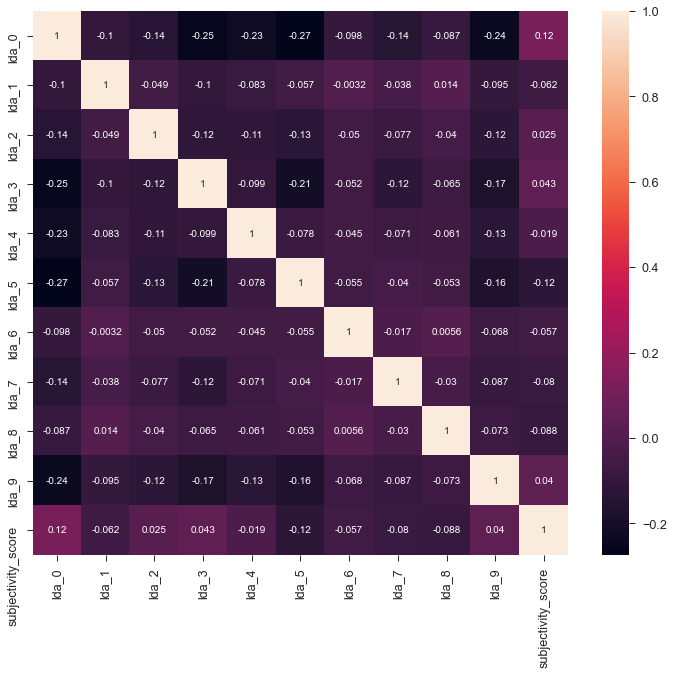

In [6]:
# plot correlation matrix
plt.figure(figsize=(12,10))
sns.heatmap(df[cont_cols].corr(), annot=True);

- Looks good! So we can go ahead and include all of these.
- Next, we'll combine the DataFrames.

In [7]:
# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

In [8]:
%%time

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], vectors_df], axis=1)
y = df['sentiment']

X.shape, y.shape

CPU times: user 50.1 s, sys: 19.1 s, total: 1min 9s
Wall time: 1min 13s


((575949, 3583), (575949,))

## Train-test-split

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Use 70% of our data as a training set and 30% as a testing set.
- Since we want to see if our engineered features improve our models beyond those using only word vectors, we'll also create separate vector-only training and testing sets.
- Our data is all on the same scale (between 0 and 1), so no scaler is necessary.

In [9]:
%%time

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

X_train.shape, X_test.shape, X_train_vec.shape, X_test_vec.shape

CPU times: user 40.3 s, sys: 48.6 s, total: 1min 28s
Wall time: 1min 48s


((403164, 3583), (172785, 3583), (403164, 3566), (172785, 3566))

# Step 2: Modeling

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- We'll test out untuned Naive Bayes (Bernoulli and Multinomial) and Decision Tree models on both our vectors-only sets and vectors-plus-features sets.
- Because the dataset is so large (in both rows and columns) and cross-validation is so intensive, we are only able to use train-test split to cross-validate.
- After an initial run through our basic models, we'll tune parameters.
- Finally, we can train and save a final model.

### Bernoulli Naive Bayes - vectors only

In [11]:
%%time

# create Bernoulli Naive Bayes object
bnb_vec = BernoulliNB()

# train model
benaba_vec = bnb_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_bnb_vec = benaba_vec.predict(X_train_vec)
y_test_pred_bnb_vec = benaba_vec.predict(X_test_vec)

CPU times: user 2min 50s, sys: 1min 26s, total: 4min 17s
Wall time: 4min 39s


In [12]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_bnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_bnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_bnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_bnb_vec, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_bnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_bnb_vec))

-----TRAIN-----
Accuracy: 0.7157608318203014
F1 score: 0.7176953642255267
Recall: 0.7157608318203014
Precision: 0.7257952387590993

-----TEST-----
Accuracy: 0.7127528431287438
F1 score: 0.7147691967836526
Recall: 0.7127528431287438
Precision: 0.7228616573206086

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.70      0.72     66413
    positive       0.59      0.76      0.66     34605
     neutral       0.78      0.71      0.74     71767

    accuracy                           0.71    172785
   macro avg       0.70      0.72      0.71    172785
weighted avg       0.72      0.71      0.71    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[46191  9548 10674]
 [ 4383 26204  4018]
 [12124  8885 50758]]


- Not bad! Very well fit and decent F1 scores, though it struggles a bit in identifying *positive* tweets.
- Let's take a quick look at important features and confusion matrices.

#### Feature importances

In [ ]:
print_nb_features(benaba_vec, X_train_vec, ['positive', 'neutral', 'negative'])

In [13]:
# sorted features per class by importance
pos_class_prob_sorted = benaba_vec.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_vec.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_vec.feature_log_prob_[2, :].argsort()

# printout of each class's top 10
print(f'Positive tweets:\n{", ".join(list(np.take(X_train_vec.columns, pos_class_prob_sorted[:10])))}\n')
print(f'Neutral tweets:\n{", ".join(list(np.take(X_train_vec.columns, neu_class_prob_sorted[:10])))}\n')
print(f'Negative tweets:\n{", ".join(list(np.take(X_train_vec.columns, neg_class_prob_sorted[:10])))}')

Positive tweets:
#wholesale, okhand, #sale, smilingfacewith3, faceblowingakiss, #healthy, #safe, purpleheart, blueheart, twohearts

Neutral tweets:
#love, celebrate, smilingfacewithheart, smilingfacewith3, okhand, incompetent, incompetence, improve, violent, loss

Negative tweets:
iniran, assault, thief, incompetence, suicide, germany's, #fight, fails, threatens, declares


#### Confusion matrix

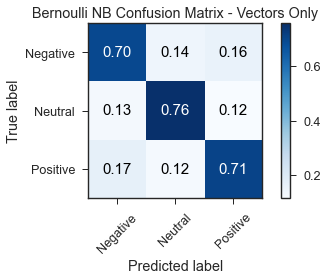

In [47]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/bnb_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

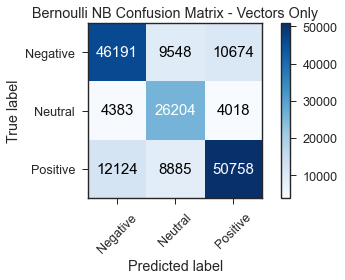

In [15]:
# plot confusion matrix - quantity
cm_benaba = confusion_matrix(y_test, y_test_pred_bnb_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

- It's interesting that hashtags and emojis are so important for *positive* and *neutral* tweets, but not *negative* tweets.
- Could it be that tweets with these "words" tend to be more *positive*, or does the VADER sentiment analyzer weight them more positively? It's difficult to tell here, but maybe in the future, we can try removing hashtags and emojis and see how that affects our results.

### Bernoulli Naive Bayes - numerical data + vectors

In [17]:
%%time

# create Bernoulli Naive Bayes object
bnb_combo = BernoulliNB()

# train model
benaba_combo = bnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_pred_train_bnb_combo = benaba_combo.predict(X_train)
y_pred_test_bnb_combo = benaba_combo.predict(X_test)

CPU times: user 3min 4s, sys: 1min 50s, total: 4min 55s
Wall time: 5min 26s


In [18]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_pred_train_bnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_pred_train_bnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_bnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_pred_test_bnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_pred_test_bnb_combo, average="weighted")}')


print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_pred_test_bnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_pred_test_bnb_combo))

-----TRAIN-----
Accuracy: 0.6254229048228512
F1 score: 0.6347419976743295
Recall: 0.6254229048228512
Precision: 0.6747955930823033

-----TEST-----
Accuracy: 0.6233237838932778
F1 score: 0.6325810019992972
Recall: 0.6233237838932778
Precision: 0.673085341549466

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.72      0.59      0.65     66413
    positive       0.42      0.75      0.54     34605
     neutral       0.75      0.59      0.66     71767

    accuracy                           0.62    172785
   macro avg       0.63      0.64      0.62    172785
weighted avg       0.67      0.62      0.63    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[39274 17258  9881]
 [ 4331 25937  4337]
 [10754 18523 42490]]


- Wow! Much worse, with similar problems identifying *positive* tweets.
- A quick look at important features below shoes no major differences.
- The confusion matrices show that *neutral* tweets are still the most effectively predicted, without any loss by using the other features.

#### Feature importances

In [19]:
# sorted features per class by importance
pos_class_prob_sorted = benaba_combo.feature_log_prob_[0, :].argsort()
neu_class_prob_sorted = benaba_combo.feature_log_prob_[1, :].argsort()
neg_class_prob_sorted = benaba_combo.feature_log_prob_[2, :].argsort()

# printout of each class's top 10
print(np.take(X.columns, pos_class_prob_sorted[:10]))
print(np.take(X.columns, neu_class_prob_sorted[:10]))
print(np.take(X.columns, neg_class_prob_sorted[:10]))

Index(['#wholesale', '#sale', 'okhand', 'faceblowingakiss', 'smilingfacewith3',
       '#healthy', '#safe', 'purpleheart', 'smilingfacewithheart', '#love'],
      dtype='object')
Index(['improve', '#love', 'smilingfacewith3', 'smilingfacewithheart',
       'celebrate', 'okhand', 'incompetence', 'incompetent', 'creative',
       'illegal'],
      dtype='object')
Index(['iniran', 'assault', 'thief', 'suicide', 'incompetence', 'germany's',
       'fails', '#fight', 'threatens', 'violence'],
      dtype='object')


#### Confusion matrix

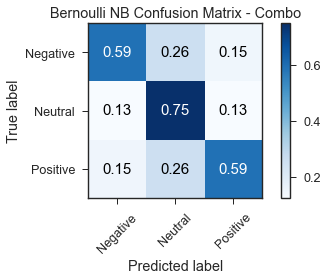

In [20]:
# plot confusion matrix - normalized
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=True,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

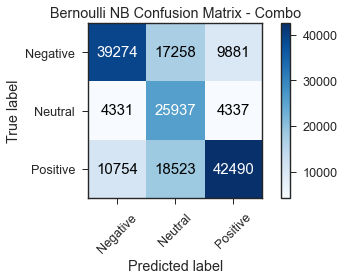

In [21]:
# plot confusion matrix - quantity
cm_benaba = confusion_matrix(y_test, y_pred_test_bnb_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_benaba, classes, normalize=False,
                      title='Bernoulli NB Confusion Matrix - Combo', cmap=plt.cm.Blues)

### Multinomial Naive Bayes - vectors only

In [22]:
%%time

# create Multinomial Naive Bayes object
mnb_vec = MultinomialNB()

# train model
munaba_vec = mnb_vec.fit(X_train_vec, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_vec = munaba_vec.predict(X_train_vec)
y_test_pred_mnb_vec = munaba_vec.predict(X_test_vec)

CPU times: user 27.2 s, sys: 16.8 s, total: 44 s
Wall time: 35.1 s


In [23]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_vec))

-----TRAIN-----
Accuracy: 0.692006230715044
F1 score: 0.6774887034891885
Recall: 0.692006230715044
Precision: 0.6965605413145178

-----TEST-----
Accuracy: 0.688057412391122
F1 score: 0.6733511536832583
Recall: 0.688057412391122
Precision: 0.6918766959418424

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.75      0.72     66413
    positive       0.72      0.33      0.45     34605
     neutral       0.67      0.80      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.63      0.64    172785
weighted avg       0.69      0.69      0.67    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49856  2441 14116]
 [ 9189 11531 13885]
 [12122  2146 57499]]


- Similar results but worse across the board.
- We'll see if our features improve it.

### Multinomial Naive Bayes - numerical data + vectors

In [25]:
%%time

# create Multinomial Naive Bayes object
mnb_combo = MultinomialNB()

# train model
munaba_combo = mnb_combo.fit(X_train, y_train)

# predict on corresponding train and test data
y_train_pred_mnb_combo = munaba_combo.predict(X_train)
y_test_pred_mnb_combo = munaba_combo.predict(X_test)

CPU times: user 43.7 s, sys: 42 s, total: 1min 25s
Wall time: 1min 26s


In [26]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_mnb_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_mnb_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_mnb_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_mnb_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_mnb_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_mnb_combo))

-----TRAIN-----
Accuracy: 0.6970711670684883
F1 score: 0.6885496709793402
Recall: 0.6970711670684883
Precision: 0.6990540461976077

-----TEST-----
Accuracy: 0.6945741817866135
F1 score: 0.6860664695731379
Recall: 0.6945741817866135
Precision: 0.6962108790803943

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.70      0.74      0.72     66413
    positive       0.71      0.42      0.52     34605
     neutral       0.69      0.79      0.73     71767

    accuracy                           0.69    172785
   macro avg       0.70      0.65      0.66    172785
weighted avg       0.70      0.69      0.69    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[49245  3202 13966]
 [ 8829 14390 11386]
 [12748  2642 56377]]


- Interesting! Actually a very slight increase here, but still not enough to beat our first model.

### Decision Tree - untuned - vectors only

⏰ NOTE: Next cell took me 1 hour and 15 minutes to run.

In [28]:
%%time

# basic decision tree with class weights balanced
tree_vec = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_vec.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec = tree_vec.predict(X_train_vec)
y_test_pred_tree_vec = tree_vec.predict(X_test_vec)

CPU times: user 1h 13min 50s, sys: 39.1 s, total: 1h 14min 29s
Wall time: 1h 15min 2s


In [29]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec))

-----TRAIN-----
Accuracy: 0.9960685973946086
F1 score: 0.9960746024747931
Recall: 0.9960685973946086
Precision: 0.996101175153244

-----TEST-----
Accuracy: 0.7465173481494343
F1 score: 0.7462871524382707
Recall: 0.7465173481494343
Precision: 0.7464430597980899

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.72      0.73     66413
    positive       0.75      0.80      0.77     34605
     neutral       0.76      0.75      0.75     71767

    accuracy                           0.75    172785
   macro avg       0.75      0.75      0.75    172785
weighted avg       0.75      0.75      0.75    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[47868  4712 13833]
 [ 3512 27614  3479]
 [13743  4519 53505]]


- Well, it took over an hour to run, but it gave us a decent 3% bump in F1 score. It appears that almost all of this can be attributed to much more accurate predictions of the *positive* class.
- Unsurprisingly, the model is incredibly overfit, as Decision Trees often are. We'll see if we can improve the fit (so that it can better generalize on unseen data) later on, in the [parameter tuning](#Parameter-tuning) section.
- Let's look at which words were important, as well as some confusion matrices.

#### Feature importances

In [ ]:
# plot and print 10 most important features
plot_tree_features(
                    tree_vec,
                    X_train_vec,
                    # uncomment to save
                    file_name='charts/tree_vec_untuned_feature_importance.png'
                )

- An interesting mix of words that were frequent in *positive* tweets (*protect*, *help*, *hand*, and *please* were in the top 5 most frequent words for this class) and *negative* tweets (*infected*, *death*, and *stop* were in the top 5 for this class).
- *fight* was not a very commonly used word and didn't appear in any top 25 list.

#### Confusion matrix

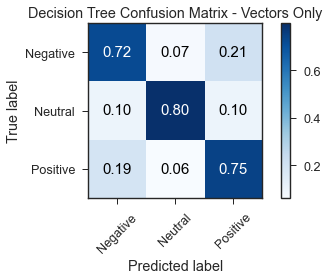

In [48]:
# plot confusion matrix - normalized
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/dt_vec_cm.png', transparent=True, bbox_inches='tight', dpi=100)

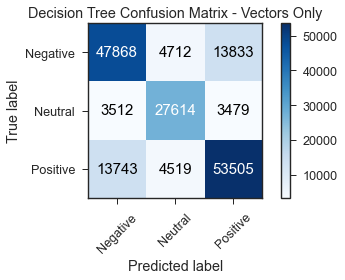

In [33]:
# plot confusion matrix - quantity
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Vectors Only', cmap=plt.cm.Blues)

### Decision Tree - untuned - numerical data and vectors

In [37]:
%%time

# basic decision tree with class weights balanced
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
tree_combo.fit(X_train, y_train)

# predict on train and test data
y_train_pred_tree_combo = tree_combo.predict(X_train)
y_test_pred_tree_combo = tree_combo.predict(X_test)

CPU times: user 28min 47s, sys: 49 s, total: 29min 36s
Wall time: 30min 17s


In [38]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_combo, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_combo)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_combo, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_combo, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_combo, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_combo))

-----TRAIN-----
Accuracy: 0.9990772985683245
F1 score: 0.9990777286787124
Recall: 0.9990772985683245
Precision: 0.9990798038289886

-----TEST-----
Accuracy: 0.6711693723413491
F1 score: 0.6713034123480605
Recall: 0.6711693723413491
Precision: 0.671738010134415

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.66      0.66      0.66     66413
    positive       0.64      0.68      0.66     34605
     neutral       0.70      0.68      0.69     71767

    accuracy                           0.67    172785
   macro avg       0.67      0.67      0.67    172785
weighted avg       0.67      0.67      0.67    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[43573  6827 16013]
 [ 5777 23429  5399]
 [16341  6460 48966]]


- Our worst model yet! Features other than the words themselves seem to not be very helpful in these models. 

#### Feature importances

In [41]:
# plot and print 10 most important features
plot_tree_features(
                    tree_vec,
                    X_train_vec
                )

[('subjectivity_score', 0.0792855920438909),
 ('lda_1', 0.030806703968522618),
 ('lda_8', 0.01926153028717357),
 ('lda_0', 0.01882909698035492),
 ('lda_9', 0.018546198836421605),
 ('lda_3', 0.01826168129087734),
 ('lda_4', 0.017448784510997864),
 ('lda_5', 0.017380610967211208),
 ('lda_6', 0.016292162384616726),
 ('lda_7', 0.015711377670566372)]

- Imagine that! The top 10 features are all ones that we engineered. Unfortunately, that doesn't matter much, since we won't be using this model, on account of its poor performance overall.
- Still, let's look at the distribution of predictions with some confusion matrices.

#### Confusion matrices

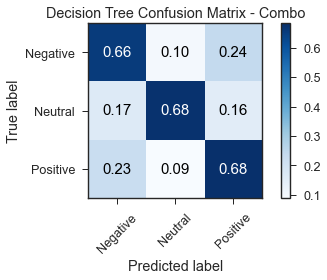

In [49]:
# plot confusion matrix - normalized
cm_tree = confusion_matrix(y_test, y_test_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/dt_combo_cm.png', transparent=True, bbox_inches='tight', dpi=100)

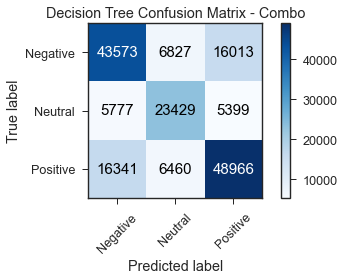

In [44]:
# plot confusion matrix - quantity
cm_tree = confusion_matrix(y_test, y_test_pred_tree_combo)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix - Combo', cmap=plt.cm.Blues)

## Parameter tuning

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Because our model is so overfit, we have to try to tune some parameters to see if we can still achieve a decent F1 score while still being able to generalize on unseen data.
- Normally, we would cross-validate using sklearn's cross_val_score, but because our dataset has so many rows and columns, we will have to stick with train-test split (which still takes a long time) and use trial and error on various parameters.
- Given the time and computing power these models require, we'll limit this section to the vectors-only version of the Decision Tree models.

### Decision Tree - vectors only - tuned v1

In [11]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned = DecisionTreeClassifier(class_weight='balanced', max_depth=1000, random_state=99)

# fit training data
tree_vec_tuned.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned = tree_vec_tuned.predict(X_train_vec)
y_test_pred_tree_vec_tuned = tree_vec_tuned.predict(X_test_vec)

CPU times: user 53min 26s, sys: 22.8 s, total: 53min 49s
Wall time: 54min 1s


In [12]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned))

-----TRAIN-----
Accuracy: 0.9824537905170104
F1 score: 0.9826847586577783
Recall: 0.9824537905170104
Precision: 0.9836661250747477

-----TEST-----
Accuracy: 0.7495442312700755
F1 score: 0.749070876779781
Recall: 0.7495442312700755
Precision: 0.7496186000277725

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.72      0.73     66413
    positive       0.75      0.82      0.78     34605
     neutral       0.76      0.74      0.75     71767

    accuracy                           0.75    172785
   macro avg       0.75      0.76      0.75    172785
weighted avg       0.75      0.75      0.75    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[47662  4957 13794]
 [ 3011 28544  3050]
 [13681  4782 53304]]


#### Feature importances

In [13]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.01539972056879534),
 ('infected', 0.014034762773132195),
 ('help', 0.013880448725082838),
 ('safe', 0.012969952436283063),
 ('hand', 0.011093674833174139),
 ('fight', 0.009559422637324426),
 ('death', 0.00949814572667467),
 ('please', 0.00927588966489719),
 ('sick', 0.009157736884093996),
 ('stop', 0.009028813629577801)]

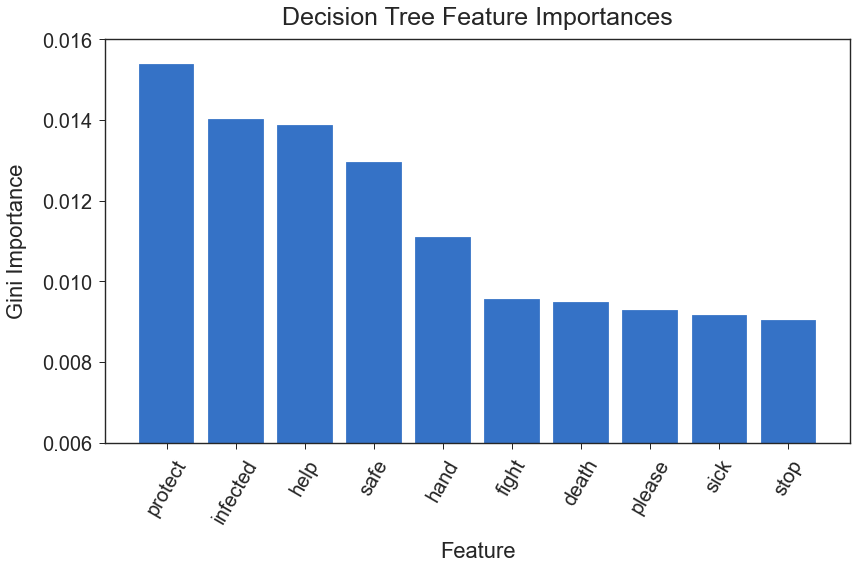

In [14]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# # uncomment to save
# plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

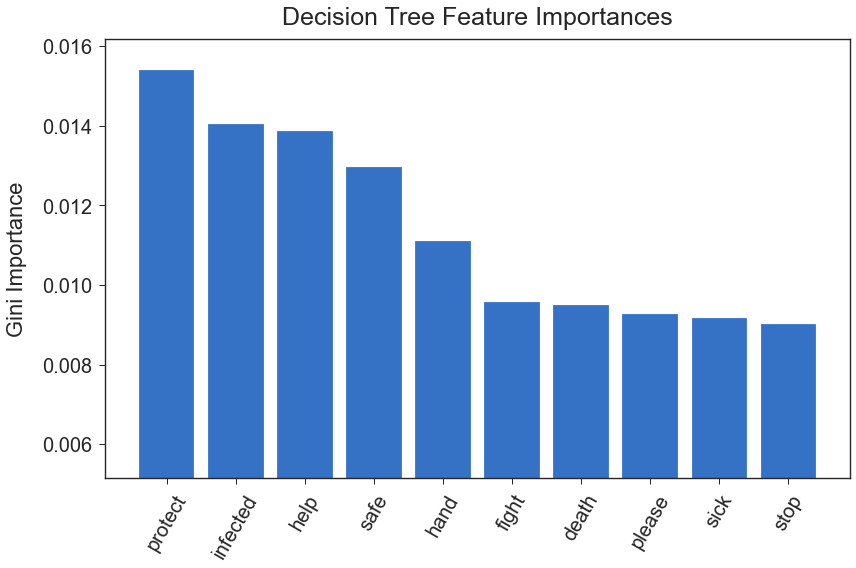





[('protect', 0.01539972056879534), ('infected', 0.014034762773132195), ('help', 0.013880448725082838), ('safe', 0.012969952436283063), ('hand', 0.011093674833174139), ('fight', 0.009559422637324426), ('death', 0.00949814572667467), ('please', 0.00927588966489719), ('sick', 0.009157736884093996), ('stop', 0.009028813629577801)]


In [45]:
plot_tree_features(tree_vec_tuned, X_train_vec)

#### Confusion matrices

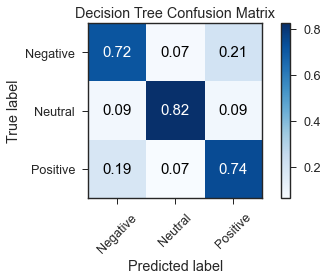

In [15]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# # uncomment to save
# plt.savefig('charts/dt_vec_tuned_cm.png', transparent=True, bbox_inches='tight', dpi=100)

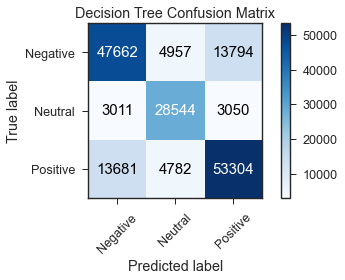

In [17]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

### Decision Tree - tuned - vectors only - v2

In [18]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned2 = DecisionTreeClassifier(class_weight='balanced', max_depth=500, random_state=99)

# fit training data
tree_vec_tuned2.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_train_vec)
y_test_pred_tree_vec_tuned2 = tree_vec_tuned2.predict(X_test_vec)

CPU times: user 41min 16s, sys: 19 s, total: 41min 35s
Wall time: 41min 43s


In [19]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned2)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned2, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned2, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned2, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned2)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned2, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned2, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned2, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned2, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned2))

-----TRAIN-----
Accuracy: 0.9473440088896826
F1 score: 0.9493940732040465
Recall: 0.9473440088896826
Precision: 0.9578144033525272

-----TEST-----
Accuracy: 0.7441965448389617
F1 score: 0.7431104341194877
Recall: 0.7441965448389617
Precision: 0.7472211968632336

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.75      0.70      0.72     66413
    positive       0.70      0.87      0.78     34605
     neutral       0.77      0.73      0.75     71767

    accuracy                           0.74    172785
   macro avg       0.74      0.77      0.75    172785
weighted avg       0.75      0.74      0.74    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[46162  6759 13492]
 [ 2111 30227  2267]
 [13252  6318 52197]]


In [20]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.01539972056879534),
 ('infected', 0.014034762773132195),
 ('help', 0.013880448725082838),
 ('safe', 0.012969952436283063),
 ('hand', 0.011093674833174139),
 ('fight', 0.009559422637324426),
 ('death', 0.00949814572667467),
 ('please', 0.00927588966489719),
 ('sick', 0.009157736884093996),
 ('stop', 0.009028813629577801)]

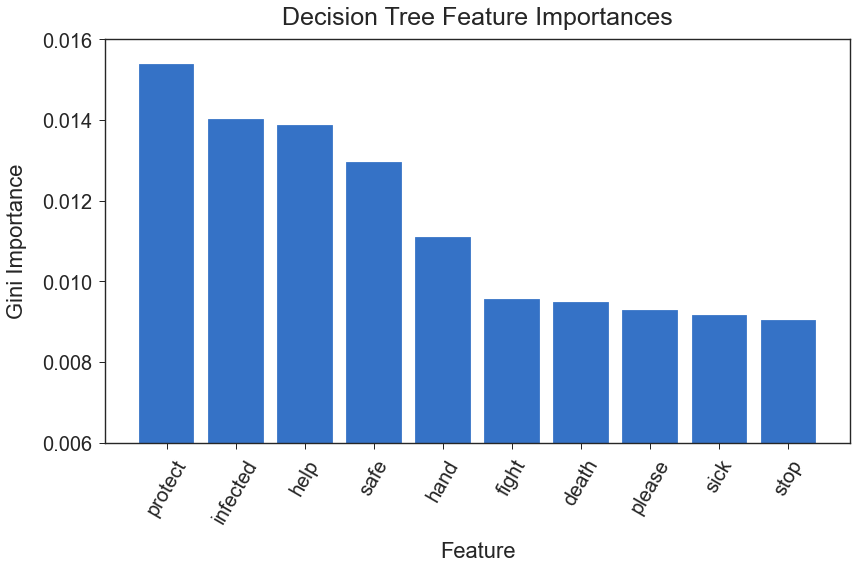

In [21]:
# top 10 most important features
tree_importance = [x[1] for x in sorted_d]

# prettify the graph
plt.figure(figsize=(12,8))
plt.title('Decision Tree Feature Importances', fontsize=25, pad=15)
plt.xlabel('Feature', fontsize=22, labelpad=15)
plt.ylabel('Gini Importance', fontsize=22, labelpad=15)
plt.ylim(bottom=0.006, top=0.016)
plt.xticks(rotation=60, fontsize=20)
plt.yticks(fontsize=20)

# plot
plt.bar([x[0] for x in sorted_d], tree_importance)

# # prepare to display and save
plt.tight_layout()
# uncomment to save
plt.savefig('charts/tuned_tree_feature_importance.png', bbox_inches='tight', transparent=True)

plt.show()

### Confusion Matrix

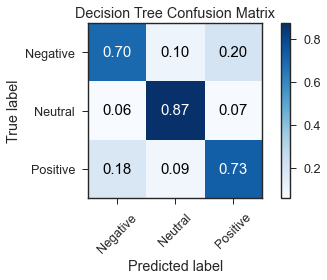

In [23]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned2)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

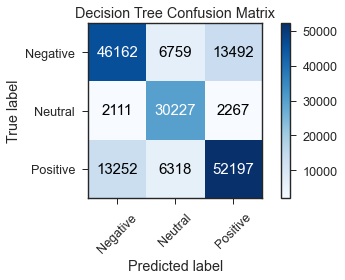

In [24]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned2)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

### Decision Tree - tuned - vectors only - v3

In [47]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned3 = DecisionTreeClassifier(class_weight='balanced', min_samples_split=10, max_depth=750, random_state=99)

# fit training data
tree_vec_tuned3.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned3 = tree_vec_tuned3.predict(X_train_vec)
y_test_pred_tree_vec_tuned3 = tree_vec_tuned3.predict(X_test_vec)

CPU times: user 49min 40s, sys: 27.6 s, total: 50min 8s
Wall time: 50min 27s


In [48]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned3)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned3, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned3, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned3, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned3)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned3, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned3, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned3, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned3, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned3))

-----TRAIN-----
Accuracy: 0.9351703029040291
F1 score: 0.9360230771003475
Recall: 0.9351703029040291
Precision: 0.9406958743144301

-----TEST-----
Accuracy: 0.7475706803252598
F1 score: 0.7467828355647058
Recall: 0.7475706803252598
Precision: 0.7491742438571428

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.74      0.71      0.73     66413
    positive       0.72      0.86      0.78     34605
     neutral       0.77      0.73      0.75     71767

    accuracy                           0.75    172785
   macro avg       0.74      0.77      0.75    172785
weighted avg       0.75      0.75      0.75    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[47116  5992 13305]
 [ 2656 29595  2354]
 [13598  5711 52458]]


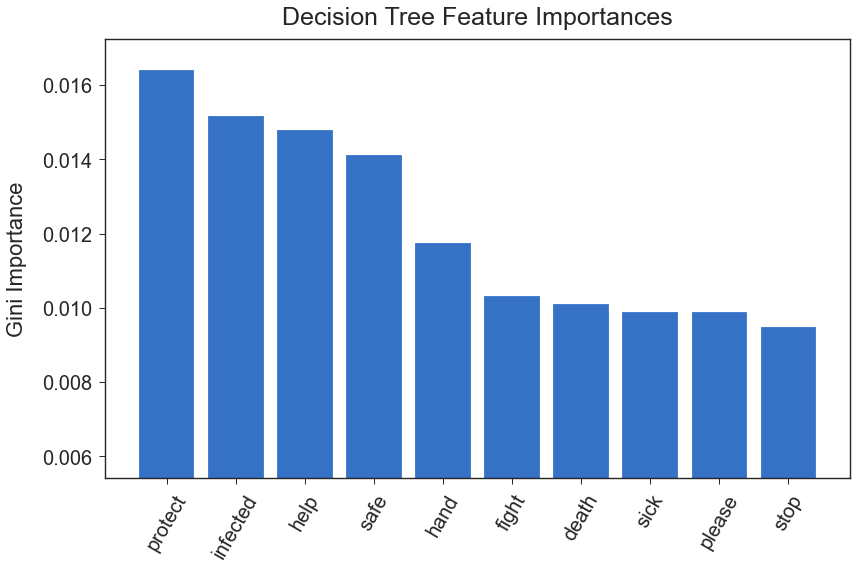





[('protect', 0.016409377135477188), ('infected', 0.01515930626970012), ('help', 0.014781132578778073), ('safe', 0.014107487844675339), ('hand', 0.01174267019569047), ('fight', 0.010303567467952256), ('death', 0.01010569156571655), ('sick', 0.009880990454186266), ('please', 0.00988044879524244), ('stop', 0.00949463630250009)]


In [49]:
plot_tree_features(tree_vec_tuned3, X_train_vec)

In [32]:
features_dict = dict(zip(X_train_vec.columns, tree_vec_tuned3.feature_importances_))
sorted_d = sorted(features_dict.items(), key=lambda x: x[1], reverse=True)[:10]
sorted_d

[('protect', 0.017226919441524165),
 ('infected', 0.01595656384680281),
 ('help', 0.015462155596468631),
 ('safe', 0.014825122747221045),
 ('hand', 0.0123820419308646),
 ('fight', 0.010973954818615003),
 ('death', 0.010554380185795478),
 ('please', 0.010410615446992113),
 ('sick', 0.010401631001913294),
 ('stop', 0.010003264883015346)]

In [37]:
sorted_d[0][1] * 1.1

0.018949611385676583

### Confusion Matrix

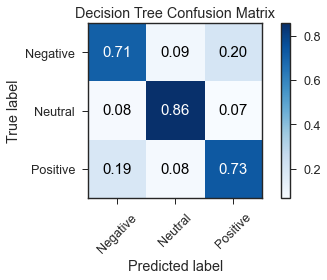

In [54]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned3)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

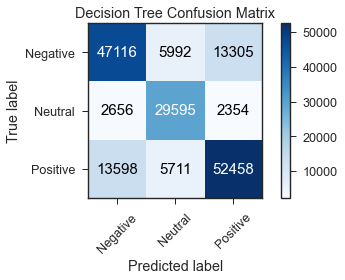

In [55]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned3)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [51]:
%%time

clf = DecisionTreeClassifier(random_state=99)
path = clf.cost_complexity_pruning_path(X_train_vec, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

CPU times: user 1h 8min 57s, sys: 19.2 s, total: 1h 9min 16s
Wall time: 1h 9min 36s


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

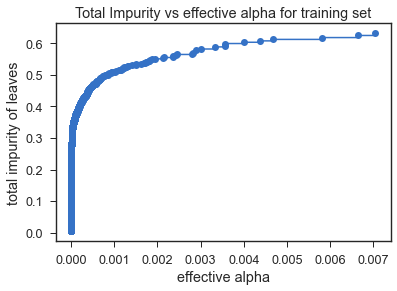

In [53]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [70]:
len(ccp_alphas)

23121

### Decision Tree - tuned - vectors only - v4

In [56]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned4 = DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.001, random_state=99)

# fit training data
tree_vec_tuned4.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned4 = tree_vec_tuned4.predict(X_train_vec)
y_test_pred_tree_vec_tuned4 = tree_vec_tuned4.predict(X_test_vec)

CPU times: user 1h 15min 29s, sys: 29.9 s, total: 1h 15min 59s
Wall time: 1h 16min 21s


In [57]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned4)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned4, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned4, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned4, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned4)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned4, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned4, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned4, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned4, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned4))

-----TRAIN-----
Accuracy: 0.6058675873837942
F1 score: 0.6077656760822735
Recall: 0.6058675873837942
Precision: 0.6849960523994996

-----TEST-----
Accuracy: 0.6080967676592297
F1 score: 0.6104497530742122
Recall: 0.6080967676592297
Precision: 0.687497319957957

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.78      0.44      0.56     66413
    positive       0.42      0.90      0.57     34605
     neutral       0.73      0.62      0.67     71767

    accuracy                           0.61    172785
   macro avg       0.64      0.65      0.60    172785
weighted avg       0.69      0.61      0.61    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[29311 22701 14401]
 [ 1237 31033  2335]
 [ 6862 20179 44726]]


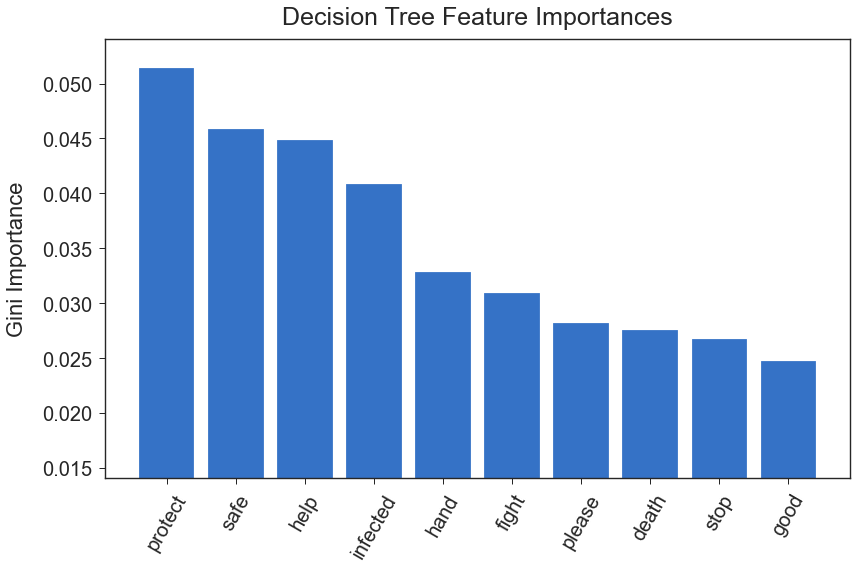





[('protect', 0.051441563837305804), ('safe', 0.04590243437483001), ('help', 0.044851399833696855), ('infected', 0.04088929453522823), ('hand', 0.032851132084421086), ('fight', 0.03091834024522218), ('please', 0.028209985517751113), ('death', 0.027556872496499043), ('stop', 0.02676092423927733), ('good', 0.024745703625741272)]


In [58]:
plot_tree_features(tree_vec_tuned4, X_train_vec)

### Confusion Matrix

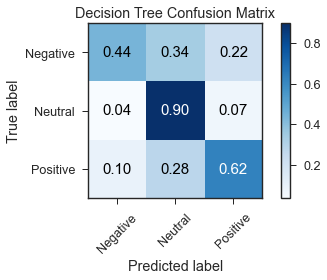

In [59]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned4)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

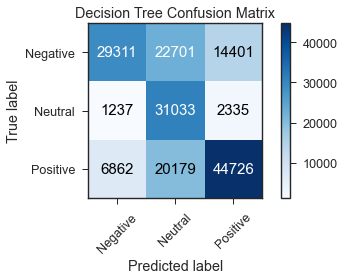

In [60]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned4)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

### Decision Tree - tuned - vectors only - v4

In [61]:
%%time

# basic decision tree with class weights balanced
tree_vec_tuned5 = DecisionTreeClassifier(class_weight='balanced', ccp_alpha=0.0001, random_state=99)

# fit training data
tree_vec_tuned5.fit(X_train_vec, y_train)

# predict on train and test data
y_train_pred_tree_vec_tuned5 = tree_vec_tuned5.predict(X_train_vec)
y_test_pred_tree_vec_tuned5 = tree_vec_tuned5.predict(X_test_vec)

CPU times: user 1h 13min 35s, sys: 25.9 s, total: 1h 14min 1s
Wall time: 1h 14min 17s


In [65]:
# print statistics for train data
print('-----TRAIN-----')
print(f'Accuracy: {accuracy_score(y_train, y_train_pred_tree_vec_tuned5)}')
print(f'F1 score: {f1_score(y_train, y_train_pred_tree_vec_tuned5, average="weighted")}')
print(f'Recall: {recall_score(y_train, y_train_pred_tree_vec_tuned5, average="weighted")}')
print(f'Precision: {precision_score(y_train, y_train_pred_tree_vec_tuned5, average="weighted")}')
      
# print statistics for test data
print('\n-----TEST-----')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_tree_vec_tuned5)}')
print(f'F1 score: {f1_score(y_test, y_test_pred_tree_vec_tuned5, average="weighted")}')
print(f'Recall: {recall_score(y_test, y_test_pred_tree_vec_tuned5, average="weighted")}')
print(f'Precision: {precision_score(y_test, y_test_pred_tree_vec_tuned5, average="weighted")}')

print('\n' + '-' * 100 + '\n')


# print out report for test data
print(classification_report(y_test, y_test_pred_tree_vec_tuned5, target_names=y.unique()))


print('\n' + '-' * 100 + '\n')


# print out confusion matrix of test predictions
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_pred_tree_vec_tuned5))

-----TRAIN-----
Accuracy: 0.7576792570765247
F1 score: 0.7563382209630624
Recall: 0.7576792570765247
Precision: 0.7599838405071759

-----TEST-----
Accuracy: 0.7560031252712909
F1 score: 0.7546912726221272
Recall: 0.7560031252712909
Precision: 0.7586602452814231

----------------------------------------------------------------------------------------------------

              precision    recall  f1-score   support

    negative       0.78      0.68      0.73     66413
    positive       0.72      0.86      0.78     34605
     neutral       0.76      0.78      0.77     71767

    accuracy                           0.76    172785
   macro avg       0.75      0.77      0.76    172785
weighted avg       0.76      0.76      0.75    172785


----------------------------------------------------------------------------------------------------

CONFUSION MATRIX:

[[45152  6281 14980]
 [ 1973 29746  2886]
 [10705  5334 55728]]


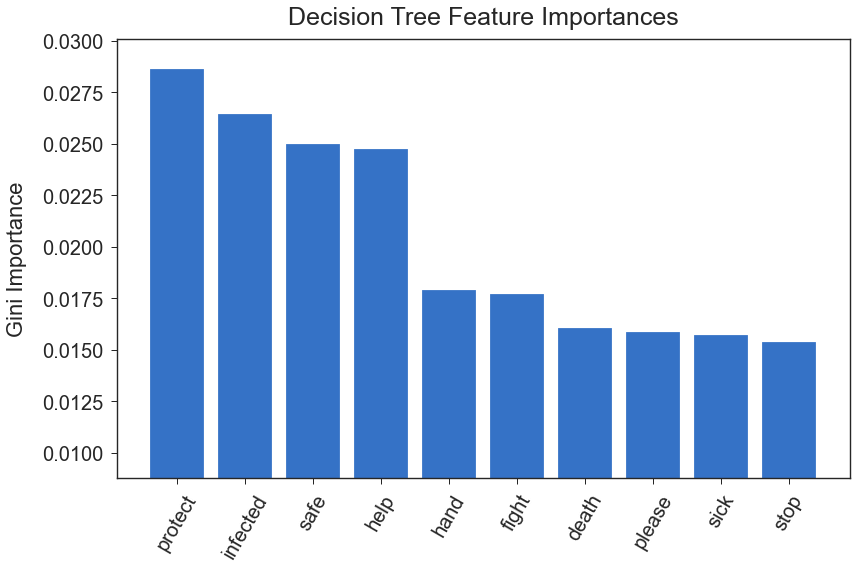





[('protect', 0.028642516319752637), ('infected', 0.026430204083235712), ('safe', 0.02498604098293319), ('help', 0.024751522264474374), ('hand', 0.017881834455542128), ('fight', 0.017695848337547247), ('death', 0.016075621022268418), ('please', 0.015875569681892743), ('sick', 0.015736201596727256), ('stop', 0.015385585335192827)]


In [66]:
plot_tree_features(tree_vec_tuned5, X_train_vec)

### Confusion Matrix

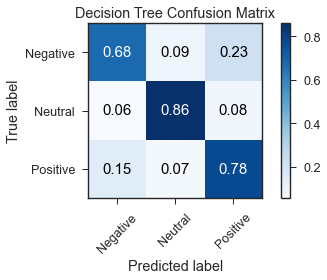

In [67]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned5)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=True,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

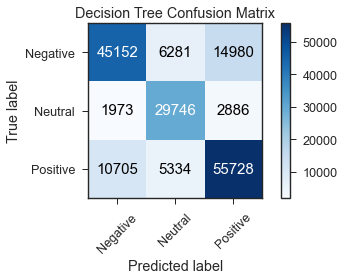

In [68]:
cm_tree = confusion_matrix(y_test, y_test_pred_tree_vec_tuned5)
classes = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm_tree, classes, normalize=False,
                      title='Decision Tree Confusion Matrix', cmap=plt.cm.Blues)

# plt.savefig('Images/dt_conf_matrix.png', dpi = 100)

In [75]:
tree_vec.tree_.node_count

NameError: name 'tree_vec' is not defined

In [74]:
tree_vec_tuned5.tree_.node_count

1103

In [77]:
tree_vec_tuned.tree_.max_depth

1000

In [76]:
tree_vec_tuned5.tree_.max_depth

477

In [80]:
tree_vec_tuned.tree_.n_leaves

56120

In [78]:
tree_vec_tuned5.tree_.n_leaves

552

# Step 3: Reproducibility

[[go back to the top](##Masks-Throughout-COVID-19:-A-Twitter-Sentiment-Analysis)]

- Below are the required packages and other information.

In [ ]:
%load_ext watermark
%watermark -a 'Joshua Szymanowski' -nmv --packages numpy,pandas,sklearn,scipy,matplotlib,\
                                                    seaborn,nltk,gensim,textblob,pickle,gzip

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

# text processing/nlp packages
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, \
    recall_score, f1_score, confusion_matrix, classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
data_vec = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

    #----IMPORTANT NOTE----#
# Our corpus has changed slightly after updating the clean_text function, 
# so we will be loading the original corpus, in order to keep our original topics.
# If you wish to create new topics, uncomment commented code below.

# # one of the required inputs is a term-document matrix
# tdm = data_vec.transpose()
# tdm.head()

# # put the term-document matrix into a new gensim format, 
# # from df ==> sparse matrix ==> gensim corpus
# # NOTE: MAY TAKE A FEW MINUTES
# sparse_counts = csr_matrix(tdm)
# corpus = Sparse2Corpus(sparse_counts)

# # gensim also requires dictionary of the all terms and their respective location in the term-document matrix
# id2word = dict((v, k) for k, v in tf_idf.vocabulary_.items())

# # create the topics
# lda = LdaModel(
#                 corpus=corpus, 
#                 id2word=id2word, 
#                 num_topics=10, 
#                 passes=100, 
#                 iterations=100
#             )

    #----IMPORTANT NOTE----#
# If you chose to create your own corpus/topics, comment out these cells

# load gensim corpus
with gzip.open('data/gensim_corpus_orig.pkl', 'rb') as hello_c:
    corpus = pickle.load(hello_c)
# load vocab location dictionary
with gzip.open('data/gensim_id2word_orig.pkl', 'rb') as hello_i:
    id2word = pickle.load(hello_i)
# load topics
with gzip.open('models/lda_10topics_100passes.pkl', 'rb') as hello:
    lda = pickle.load(hello)
#-----------------------------#

# corpus from LDA model
corpus_transformed = lda[corpus]

# convert lda tuples to dictionary
lda_topics_dict = [dict(x) for x in corpus_transformed]

# convert list of lda topic weights to dataframe
lda_df = pd.DataFrame(lda_topics_dict)

# rename columns
lda_df.rename(columns={i: f'lda_{i}' for i in range(10)}, inplace=True)

# replace NaNs with 0
lda_df.fillna(0, inplace=True)

# combine with original dataframe
df = pd.concat([df, lda_df], axis=1)

# create subjectivity score column
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# dummy months dataframe
month_dummies = pd.get_dummies(df.month, drop_first=True)

# reformat column names
month_dummies.columns = ['february', 'march', 'april', 'may']

# combine dataframe and dummy columns; drop columns
df = pd.concat([df, month_dummies], axis=1).drop(columns='month')

# convert to categorical dummy based on whether a tweet received likes or not
df['likes'] = np.where(df.nlikes > 0, 1, 0)

# convert to categorical dummy based on whether a tweet received likes or not
df['replies'] = np.where(df.nreplies > 0, 1, 0)

# list of columns to use as features
feature_cols = [
    'lda_0', 'lda_1', 'lda_2', 'lda_3', 'lda_4',
    'lda_5', 'lda_6', 'lda_7', 'lda_8', 'lda_9', 
    'subjectivity_score', 'february', 'march', 
    'april', 'may', 'replies', 'likes'
]

# combine features columns and word vectors dataframe
X = pd.concat([df[feature_cols], data_vec], axis=1)
y = df['sentiment']

# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# create vectors-only training and test sets (removing the first 17 columns)
X_train_vec = X_train.iloc[:,17:]
X_test_vec = X_test.iloc[:,17:]

# basic decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(classification_report(y_test, y_preds, target_names=y.unique()))

In [ ]:
%%time

# standard packages
import numpy as np
import pandas as pd

# text processing/nlp packages
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# modeling packages
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# saving/loading packages
import gzip
import pickle

# custom functions
from functions import *

# load dataframe
with gzip.open('data/jan_thru_may_labeled_mask_tweets.pkl', 'rb') as hello:
    df = pickle.load(hello)
    
# create stop words list
stop_words = stopwords.words('english')
# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']
# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people',
                  'us', 'like', 'n95', 'go', 'going', 'would', 
                  'surgical', 'via', 'also', 'use', 'even', 'know']
stop_words += eda_stop_words

# create column of processed text
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# custom pattern to tokenize words -- includes hashtags, words with numbers, and contractions
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-z]+)?)"

# instantiate a document-term matrix using TfidfVectorizer
# only take words with at least 250 appearances
tf_idf = TfidfVectorizer(min_df=250, token_pattern=pattern)

# run vectorizor
data_tf_idf = tf_idf.fit_transform(df.clean_tweet)

# convert to DataFrame
X_final = pd.DataFrame(data_tf_idf.toarray(), columns=tf_idf.get_feature_names())

# target variable
y = df['sentiment']

# split into train and test data
X_train_vec, X_test_vec, y_train, y_test = train_test_split(X_final, y, test_size=0.3, stratify=y, random_state=1)

# basic decision tree with class weights balanced
dt_classifier = DecisionTreeClassifier(class_weight='balanced', random_state=99)

# fit training data
dt_classifier.fit(X_train_vec, y_train)

# predict on test data
y_preds = tree_vec.predict(X_test_vec)

# print out report for test data
print(classification_report(y_test, y_preds, target_names=y.unique()))